In [227]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d

from pathlib import Path
from MITRotor import BEM, IEA10MW, IEA15MW, BEMGeometry, AerodynamicProperties, NoTipLoss, PrandtlTipLoss, ConstantInduction, KraghAerodynamics, ClassicalMomentum, UnifiedMomentum, MadsenMomentum, NoTangentialInduction, DefaultTangentialInduction, BEMSolution

In [228]:
rotor = IEA10MW()

In [229]:
def extract_columns(file_list):
    data_dict = {}
    
    for file in file_list:
        with open(file, 'r') as f:
            lines = f.readlines()
            
            # Skip the header line and extract columns 1, 4, and 5
            data = np.loadtxt(lines[1:])[:, [0, 3, 4]]
            
            # Use the filename without the path and extension as the dictionary key
            key = Path(file).parent.name
            data_dict[key] = data
    
    return data_dict

In [230]:
file_list = glob.glob("/scratch/09909/smata/wrf_les_sweep/runs/10MW/gad_sweep/*/input_sounding")

data = extract_columns(file_list)

t = np.linspace(0,2*np.pi,158)
r = np.linspace(0,1,26)

R, T = np.meshgrid(r, t)

X = R * np.sin(T)
Y = (R * np.cos(T)) * rotor.R + 378

In [231]:
fontsize = 24
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [232]:
casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']
# casenames = [r's4_v0']

wrfles_bem = []
for count, name in enumerate(casenames):
    wrfles_bem.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/10MW/gad_sweep/'+casenames[count]+'_new.npz')))


/tmp/ipykernel_3070832/530360417.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[xs[count],ys[count]].scatter(ind, ct, cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=0.25,zorder=1)
/tmp/ipykernel_3070832/530360417.py:54: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[xs[count],ys[count]].scatter(ind_rotor, ct_rotor, cmap='viridis', s=110, edgecolor='none',color='#ffc300',alpha=1,zorder=4)
/tmp/ipykernel_3070832/530360417.py:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[4,4].scatter(ind, ct, cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=0.05)


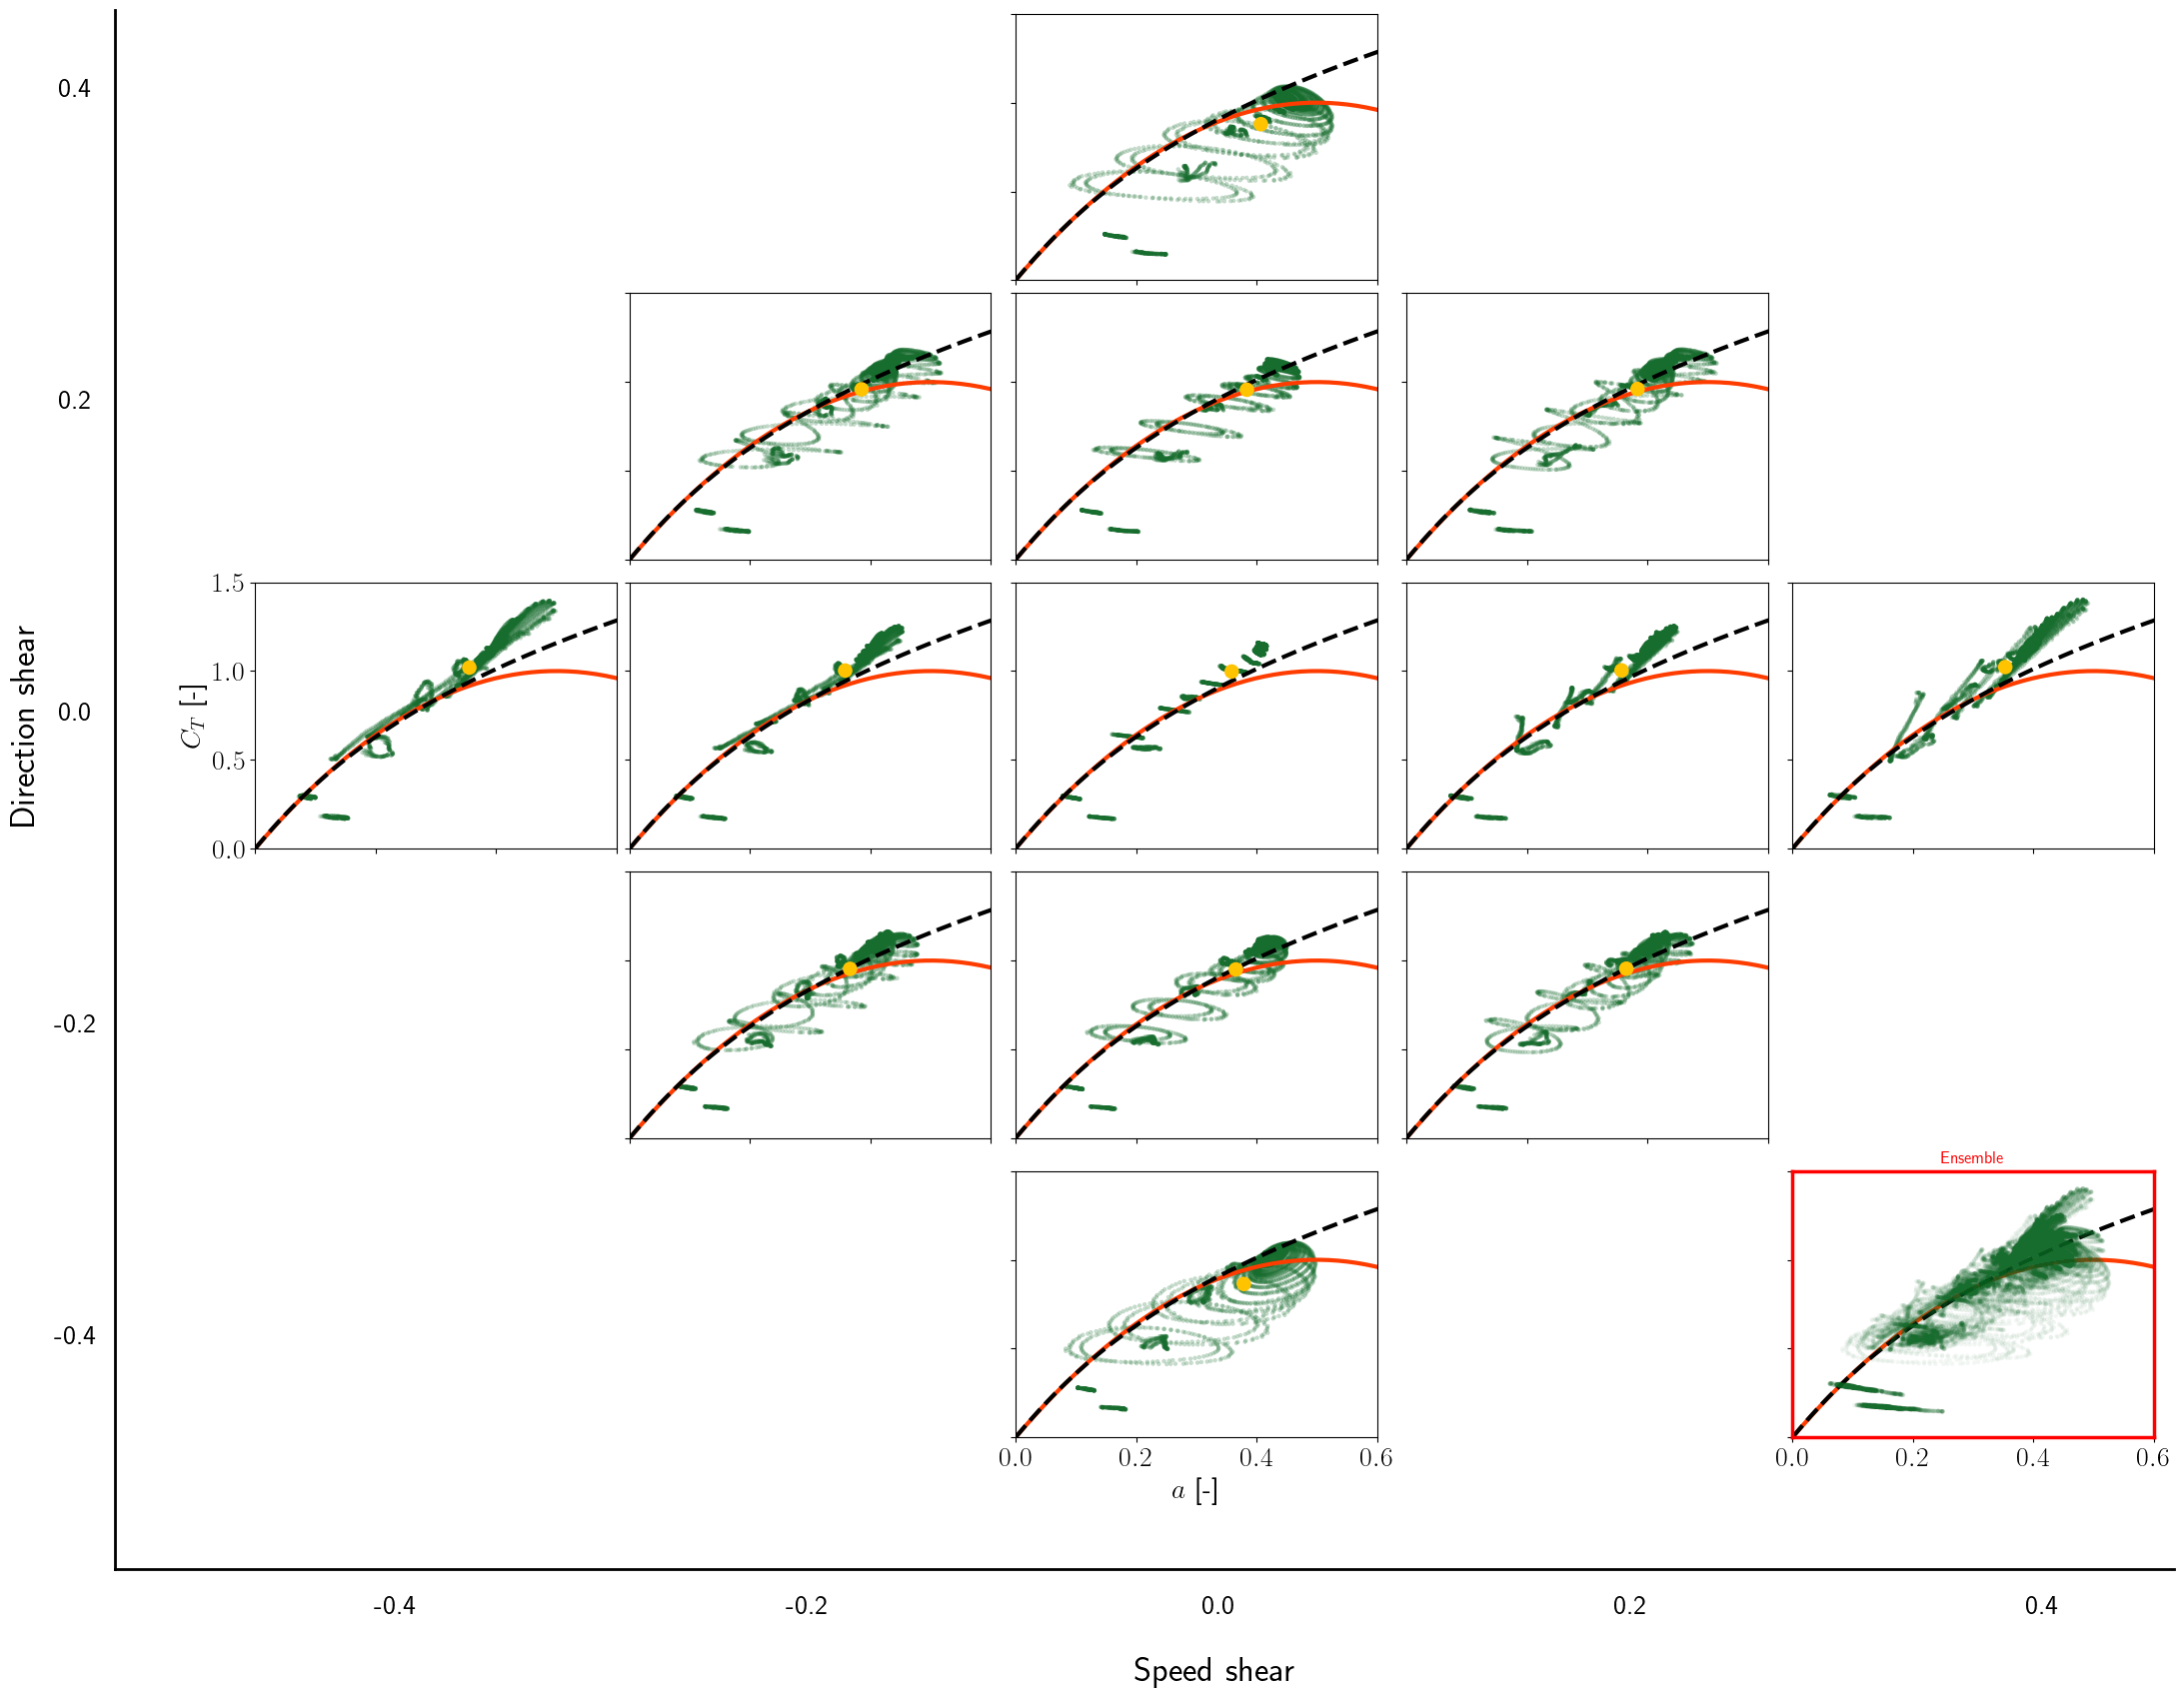

In [245]:
xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 15), constrained_layout=True,sharex=True, sharey=True)


for count,case in enumerate(casenames):
    u_func = interp1d(data[case][:,0], data[case][:,1], kind='linear')
    v_func = interp1d(data[case][:,0], data[case][:,2], kind='linear')

    u_inf = u_func(Y)
    v_inf = v_func(Y)

    # Get radial points
    a = ((wrfles_bem[count]['rOverR'] * rotor.R) - rotor.hub_radius)/rotor.R
    r = (rotor.hub_radius + a * (rotor.R - rotor.hub_radius)) / rotor.R

    # Compute induction
    ind = 1 - np.mean(wrfles_bem[count]['u'],axis=0) / u_inf.T

    phi = np.deg2rad(np.mean(wrfles_bem[count]['phi'], axis=0))
    Cl = np.mean(wrfles_bem[count]['cl'], axis=0)
    Cd = np.mean(wrfles_bem[count]['cd'], axis=0)

    r =  (np.ones_like(Cd.T) * r).T

    # Solidity
    sigma = rotor.solidity_func(r)

    # Relative velocity
    W = np.mean(wrfles_bem[count]['vrel'], axis=0) / ((u_inf**2 + v_inf**2)**(1/2)).T
    # W = np.mean(wrfles_bem[count]['vrel'], axis=0) / 7


    # Axial coefficient
    Cax = Cl * np.cos(phi) + Cd * np.sin(phi)

    # Local CT
    ct = sigma * W**2 * Cax

    # ind = k3 * ct**3 + k2 * ct**2 + k1 * ct

    mesh = ax[xs[count],ys[count]].scatter(ind, ct, cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=0.25,zorder=1)

    ct_annular  = 1/(2 * np.pi) * np.trapezoid(ct, np.linspace(0, 2*np.pi, 158), axis=-1)
    ind_annular = 1/(2 * np.pi) * np.trapezoid(ind, np.linspace(0, 2*np.pi, 158), axis=-1)

    # ct_annular  = 1/(2 * np.pi) * np.trapezoid(ct, np.linspace(0, 2*np.pi, 158))
    # ind_annular = 1/(2 * np.pi) * np.trapezoid(ind, np.linspace(0, 2*np.pi, 158))

    ct_rotor = 2 * np.trapezoid(ct_annular * wrfles_bem[count]['rOverR'], wrfles_bem[count]['rOverR'])
    ind_rotor = 2 * np.trapezoid(ind_annular * wrfles_bem[count]['rOverR'], wrfles_bem[count]['rOverR'])

    mesh = ax[xs[count],ys[count]].scatter(ind_rotor, ct_rotor, cmap='viridis', s=110, edgecolor='none',color='#ffc300',alpha=1,zorder=4)

    # mesh = ax[xs[count],ys[count]].scatter(ind, ct, cmap='viridis', s=25, edgecolor='k')

    # ax[xs[count],ys[count]].invert_yaxis()
    # ax[xs[count],ys[count]].set_xticklabels([])
    # ax[xs[count],ys[count]].set_yticklabels([])
    # ax[xs[count],ys[count]].set_xticks([])
    # ax[xs[count],ys[count]].set_yticks([])
    a_mom = np.linspace(0,0.75,50)
    ct_mom = 4 * a_mom * (1 - a_mom)
    ax[xs[count],ys[count]].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=2)

    ct_mad = np.linspace(0,1.75,75)
    k1 = 0.2460
    k2 = 0.0586
    k3 = 0.0883
    a_mad = k3 * ct_mad**3 + k2 * ct_mad**2 + k1 * ct_mad
    ax[xs[count],ys[count]].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=3)

    # ax[xs[count],ys[count]].set_aspect('equal')
    ax[xs[count],ys[count]].set_xlim([0,0.6])
    ax[xs[count],ys[count]].set_ylim([0,1.5])

    ax[4,4].scatter(ind, ct, cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=0.05)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
# ax[4,4].axis('off')
for spine in ax[4,4].spines.values():
    spine.set_linewidth(2.5)
    spine.set_edgecolor('red')

ax[4,4].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=1)
ax[4,4].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=2)
ax[4,4].set_title('Ensemble', fontweight='bold',color='r')

ax[2,0].set_ylabel('$C_T$ [-]', fontsize=20)
ax[4,2].set_xlabel('$a$ [-]', fontsize=20)
# Add a single colorbar on the right-hand side
# cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
# cbar.set_label('Deviation in axial force from uniform [\%]',fontsize=25)


# Add the number line below the subplots
line_y = -0.04  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.03, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.14  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.52, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.03  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.04, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.15  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.01,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.46, 'Direction shear', ha='center', fontsize=25,rotation=90)

# plt.figure(dpi=700)
plt.savefig(f"/scratch/09909/smata/wrf_les_sweep/wrf_local.png", bbox_inches="tight", dpi=600)
plt.show()



/tmp/ipykernel_3070832/4199489083.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  mesh = ax.pcolormesh(X,Y,v_inf/7, cmap='viridis')


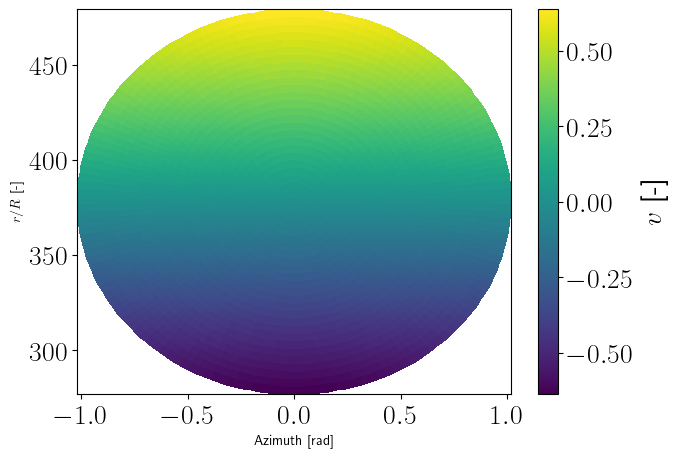

<Figure size 4480x3360 with 0 Axes>

In [234]:
fig, ax = plt.subplots(figsize=(7, 5))

mesh = ax.pcolormesh(X,Y,v_inf/7, cmap='viridis')
ax.set_xlabel('Azimuth [rad]')
ax.set_ylabel('$r/R$ [-]')
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('$v$ [-]',fontsize=20)
# ax.invert_xaxis()

plt.figure(dpi=700)
plt.show()

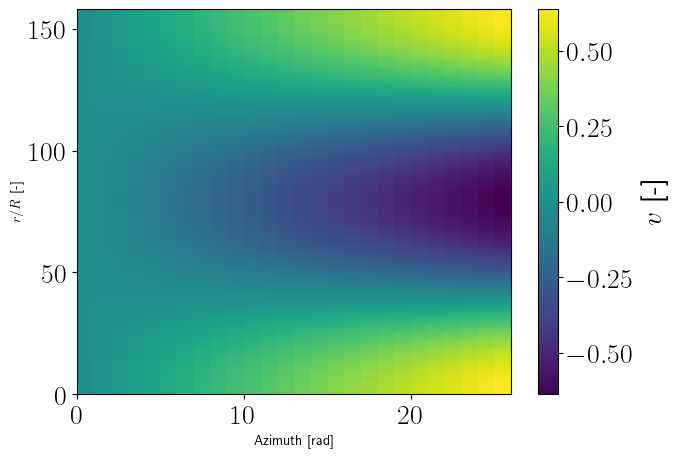

<Figure size 4480x3360 with 0 Axes>

In [235]:
fig, ax = plt.subplots(figsize=(7, 5))

mesh = ax.pcolormesh(v_inf/7, cmap='viridis')
ax.set_xlabel('Azimuth [rad]')
ax.set_ylabel('$r/R$ [-]')
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('$v$ [-]',fontsize=20)
# ax.invert_xaxis()

plt.figure(dpi=700)
plt.show()

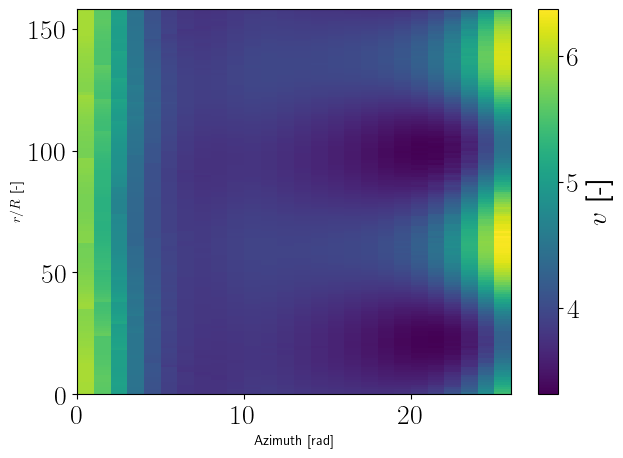

<Figure size 4480x3360 with 0 Axes>

In [236]:
fig, ax = plt.subplots(figsize=(7, 5))

mesh = ax.pcolormesh(np.mean(wrfles_bem[0]['u'],axis=0).T, cmap='viridis')
ax.set_xlabel('Azimuth [rad]')
ax.set_ylabel('$r/R$ [-]')
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('$v$ [-]',fontsize=20)
# ax.invert_xaxis()

plt.figure(dpi=700)
plt.show()

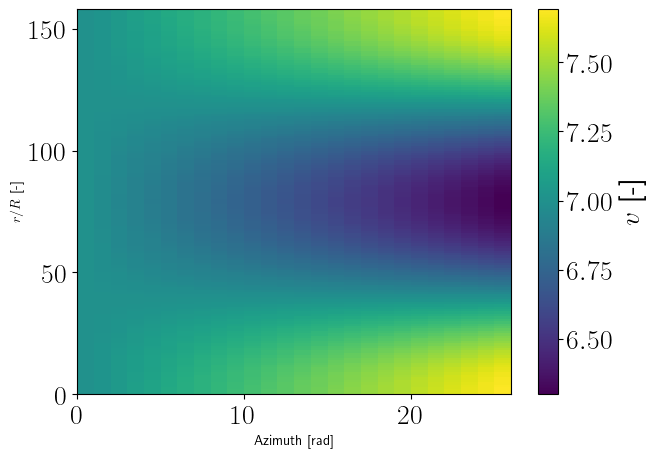

<Figure size 4480x3360 with 0 Axes>

In [237]:
fig, ax = plt.subplots(figsize=(7, 5))

u_func = interp1d(data['s2_v2'][:,0], data['s2_v2'][:,1], kind='linear')
temp = u_func(Y)

mesh = ax.pcolormesh(temp, cmap='viridis')
ax.set_xlabel('Azimuth [rad]')
ax.set_ylabel('$r/R$ [-]')
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('$v$ [-]',fontsize=20)
# ax.invert_xaxis()

plt.figure(dpi=700)
plt.show()

In [238]:
ind = 1 - np.mean(wrfles_bem[count]['u'],axis=0) / u_inf.T
ind

array([[0.103549  , 0.10358   , 0.1036146 , ..., 0.10347939, 0.10349839,
        0.10352169],
       [0.14453663, 0.14475032, 0.14486463, ..., 0.14331879, 0.14381845,
        0.14422505],
       [0.2128285 , 0.21327387, 0.21342209, ..., 0.20975079, 0.21106236,
        0.21208988],
       ...,
       [0.30999878, 0.31347472, 0.30596406, ..., 0.3385738 , 0.3330057 ,
        0.32702085],
       [0.25833491, 0.25009217, 0.24156189, ..., 0.28069735, 0.27358982,
        0.26616778],
       [0.18340547, 0.1749632 , 0.1668272 , ..., 0.20978287, 0.20083966,
        0.19204106]], shape=(26, 158))

In [239]:
for count,case in enumerate(casenames):
    print(case)

s0_v4
sn2_v2
s0_v2
s2_v2
sn4_v0
sn2_v0
s0_v0
s2_v0
s4_v0
sn2_vn2
s0_vn2
s2_vn2
s0_vn4


In [240]:
for count,case in enumerate(casenames):
    print(data[case][0,1])

7.0
8.37
7.0
5.63
9.73
8.37
7.0
5.63
4.27
8.37
7.0
5.63
7.0


In [241]:
W

array([[0.99065869, 0.99025229, 0.99017157, ..., 0.99111189, 0.99094234,
        0.99079105],
       [1.15492301, 1.15420415, 1.1540838 , ..., 1.15675956, 1.15599852,
        1.15538576],
       [1.36571596, 1.36184314, 1.36224727, ..., 1.36917462, 1.36766817,
        1.36651474],
       ...,
       [7.87857939, 7.87938132, 7.88448263, ..., 7.89207424, 7.88395571,
        7.87984342],
       [8.12570651, 8.12673933, 8.13211475, ..., 8.14061864, 8.13192312,
        8.12752285],
       [8.37032123, 8.37126007, 8.37681126, ..., 8.38654226, 8.37723733,
        8.37252182]], shape=(26, 158))

In [242]:
data[case][:,1]

array([7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7.

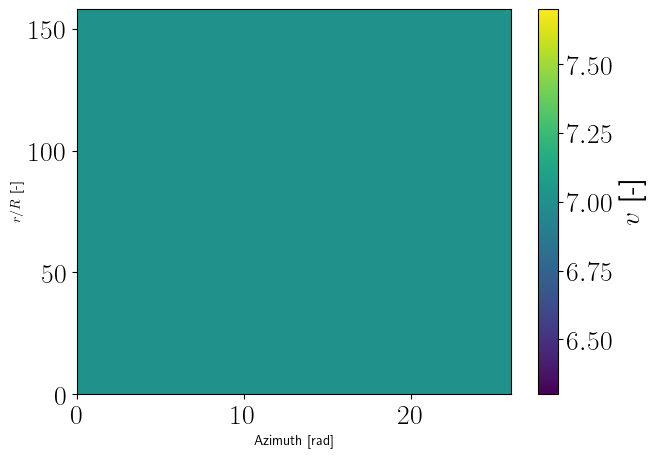

<Figure size 4480x3360 with 0 Axes>

In [243]:
fig, ax = plt.subplots(figsize=(7, 5))

mesh = ax.pcolormesh(u_inf, cmap='viridis')
ax.set_xlabel('Azimuth [rad]')
ax.set_ylabel('$r/R$ [-]')
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('$v$ [-]',fontsize=20)
# ax.invert_xaxis()

plt.figure(dpi=700)
plt.show()

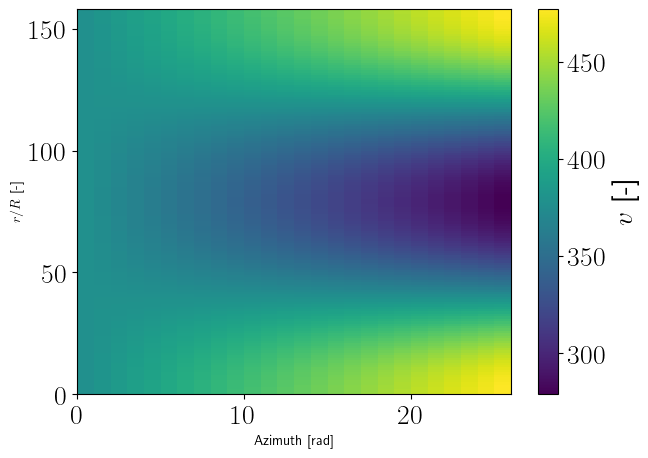

<Figure size 4480x3360 with 0 Axes>

In [244]:
fig, ax = plt.subplots(figsize=(7, 5))

mesh = ax.pcolormesh(Y, cmap='viridis')
ax.set_xlabel('Azimuth [rad]')
ax.set_ylabel('$r/R$ [-]')
cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
cbar.set_label('$v$ [-]',fontsize=20)
# ax.invert_xaxis()

plt.figure(dpi=700)
plt.show()